In [17]:
import tensorflow as tf
from tensorflow.contrib import predictor

export_dir = "model_sr50"
predict_fn = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from model_sr50/variables/variables


In [18]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [19]:
import sys 
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

In [20]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [21]:
import math
from collections import defaultdict

def jw(clauses):
    score = defaultdict(int)

    for clause in clauses:
        for l in clause:
            score[l] += 2. ** (-len(clause))

    return max(score, key=score.get)


In [22]:
LIMIT_RUNS = 1000

In [23]:
def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf

def make_normalized(cls):
    class NormalizedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None
            
            cnf = shorten_cnf(cnf)
            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)

            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    NormalizedDPLL.__name__ = "Normalized{}".format(cls.__name__)
    return NormalizedDPLL

In [24]:
np.set_printoptions(precision=3, suppress=True)

In [25]:
import tensorflow as tf
import os

BATCH_SIZE = 1

In [26]:
# Because we have to pass full batch

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        return best_svar

class MostCommonDPLL(DPLL):
    def suggest(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]
    
class JeroslawDPLL(DPLL):
    def suggest(self, cnf: CNF):
        return jw(cnf.clauses)

In [27]:
NormalizedGraphBasedDPLL = make_normalized(GraphBasedDPLL)
NormalizedMostCommonDPLL = make_normalized(MostCommonDPLL)
NormalizedJeroslawDPLL = make_normalized(JeroslawDPLL)

In [28]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps, errors

In [29]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [30]:
# s - number of samples
# n - max number of clauses, use 100 * m
# m - number of variables

def print_all(s, n, m, light=False):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        sats.append(sat)
    assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    compute_and_print_steps(sats, NormalizedGraphBasedDPLL)
    compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    compute_and_print_steps(sats, NormalizedJeroslawDPLL)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [01:04<00:00,  1.67it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 5.62; stdev step: 2.55; avg error: 0.03; stdev error: 0.17


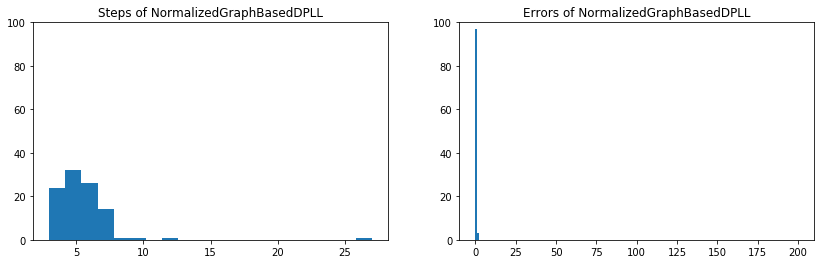

100%|██████████| 100/100 [00:00<00:00, 224.31it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.16; stdev step: 4.03; avg error: 0.83; stdev error: 0.71


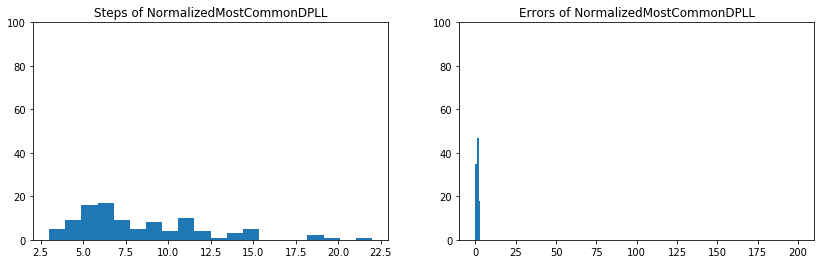

100%|██████████| 100/100 [00:00<00:00, 167.62it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 7.31; stdev step: 3.60; avg error: 0.49; stdev error: 0.56


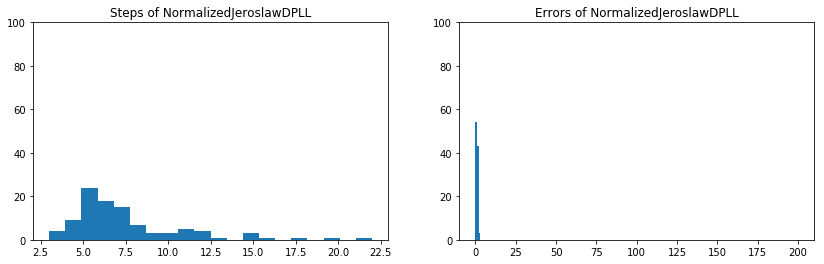

In [31]:
print_all(100, 200, 10)

In [ ]:
print_all(100, 200, 12)

In [ ]:
print_all(100, 200, 14)

In [ ]:
print_all(100, 200, 16)

In [ ]:
print_all(100, 200, 18)

In [ ]:
print_all(100, 200, 20)

In [ ]:
print_all(100, 500, 25, light=True)

In [ ]:
print_all(100, 500, 30, light=True)

In [ ]:
print_all(100, 1000, 40, light=True)

In [ ]:
print_all(100, 1000, 50, light=True)

In [ ]:
print_all(100, 1000, 70, light=True)

In [ ]:
print_all(100, 1000, 90, light=True)

In [ ]:
print_all(100, 1000, 110, light=True)